# 1. Rectified Flow для спрямления траекторий диффузии

В этой домашке мы имплементируем модель [Rectified Flow](https://arxiv.org/abs/2209.03003) для ускорения диффузионных моделей. Напомним, что модель предлагает обучать [Flow Matching](https://arxiv.org/abs/2210.02747) не на независимых парах (шум, данные), а на парах, полученных из предобученной диффузионной модели в ОДУ режиме. Такие пары имеют гораздо большую степень зависимости между собой, что позволяет более уверенно делать денойзинг из такой модели даже при больших уровнях шума. В теории же это означает, что траектории полученного ОДУ будут более прямыми, чем у оригинальной диффузионной модели (а чем прямее траектории, тем меньше шагов дискретизации нужно сделать для высокого качества генерации).

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor

## Цветной MNIST

Как и прежде, модели будем запускать на цветной версии MNIST (код для покраски взят [у коллег](https://github.com/ngushchin/EntropicNeuralOptimalTransport/blob/main/src/tools.py) из Сколтеха).

In [3]:
class ColoredMNIST(MNIST):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hues = 360 * torch.rand(super().__len__())

    def __len__(self):
        return super().__len__()

    def color_image(self, img, idx):
        img_min = 0
        a = (img - img_min) * (self.hues[idx] % 60) / 60
        img_inc = a
        img_dec = img - a

        colored_image = torch.zeros((3, img.shape[1], img.shape[2]))
        H_i = round(self.hues[idx].item() / 60) % 6

        if H_i == 0:
            colored_image[0] = img
            colored_image[1] = img_inc
            colored_image[2] = img_min
        elif H_i == 1:
            colored_image[0] = img_dec
            colored_image[1] = img
            colored_image[2] = img_min
        elif H_i == 2:
            colored_image[0] = img_min
            colored_image[1] = img
            colored_image[2] = img_inc
        elif H_i == 3:
            colored_image[0] = img_min
            colored_image[1] = img_dec
            colored_image[2] = img
        elif H_i == 4:
            colored_image[0] = img_inc
            colored_image[1] = img_min
            colored_image[2] = img
        elif H_i == 5:
            colored_image[0] = img
            colored_image[1] = img_min
            colored_image[2] = img_dec

        return colored_image

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)
        return self.color_image(img, idx), label

In [4]:
transform = Compose([Resize((32, 32)), ToTensor()])
data_train = ColoredMNIST(root='.', train=True, download=False, transform=transform)
data_test = ColoredMNIST(root='.', train=False, download=False, transform=transform)
train_dataloader = DataLoader(data_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=64, shuffle=True)

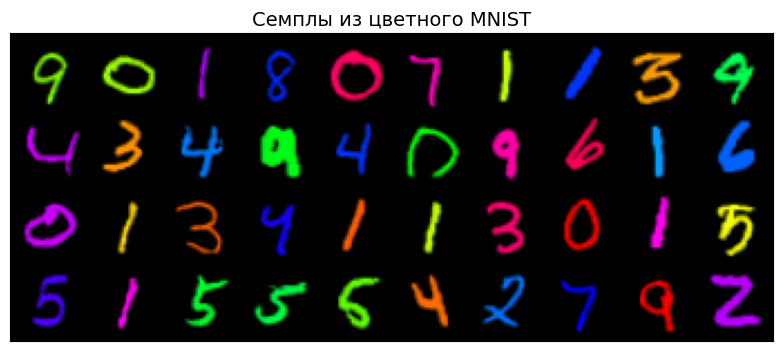

In [5]:
from torchvision.utils import make_grid

def remove_ticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        labelleft=False
    )

def remove_xticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=True,
        labelleft=True
    )

def visualize_batch(img_vis, title='Семплы из цветного MNIST', nrow=10, ncol=4):
    img_grid = make_grid(img_vis, nrow=nrow)
    fig, ax = plt.subplots(1, figsize=(nrow, ncol))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(img_grid.permute(1, 2, 0))
    plt.show()

visualize_batch(next(iter(train_dataloader))[0][:40])

## Предобученная диффузионная модель

Как и в первой домашке, мы будем использовать простенькую архитектуру, которая была получена скрещиванием CUNet из того же [репозитория](https://github.com/ngushchin/EntropicNeuralOptimalTransport/blob/main/src/cunet.py) и части, кодирующей момент времени и метку класса, из SongUNet в [EDM](https://github.com/NVlabs/edm/blob/main/training/networks.py). Далее идет повтор кода из предыдущей домашки для визуализации семплов из модели.

In [6]:
!git clone https://github.com/NVlabs/edm

fatal: destination path 'edm' already exists and is not an empty directory.


In [7]:
import sys
sys.path.append('edm')
sys.path.append('edm/training/')
sys.path.append('edm/training/networks')

import pickle
from edm.dnnlib import util
from torch_utils import misc
from cunet import CUNet

Далее мы будем работать не только с VE диффузией, но и с Flow Matching. Чтобы не переписывать один и тот же код несколько раз, заведем для диффузии и для FM по классу-обертке, которые помимо применения сети будут реализовывать подсчет векторного поля из соответствующего ОДУ и функцию, которая преобразовывает предсказание денойзера в это векторное поле.

In [8]:
# переопределим здесь EDMPrecond для простоты
class EDMPrecond(nn.Module):

    def __init__(self, model, sigma_data=0.5):
        super().__init__()
        self.sigma_data = sigma_data
        self.model = model

    def forward(self, x, sigma, class_labels=None):
        sigma = sigma.reshape(-1, 1, 1, 1)

        c_skip = self.sigma_data ** 2 / (sigma ** 2 + self.sigma_data ** 2)
        c_out = sigma * self.sigma_data / (sigma ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4

        F_x = self.model((c_in * x), c_noise.flatten(), class_labels=class_labels)
        D_x = c_skip * x + c_out * F_x
        return D_x


class DiffODE(nn.Module):
    def __init__(self, model, error_eps=1e-4):
        super().__init__()
        self.model = model
        self.error_eps = error_eps

    def forward(self, x, sigma, class_labels=None):
        return self.model(x, sigma, class_labels)

    def velocity(self, x, sigma, class_labels=None):
        sigma = sigma[:, None, None, None]
        res = (-model(x, sigma, class_labels) + x) / (sigma + self.error_eps)
        return res

    def to_velocity(self, x, sigma, x_0):
        sigma = sigma[:, None, None, None]
        res = (-x_0 + x) / (sigma + self.error_eps)
        return res


In [9]:
model = CUNet(in_channels=3, out_channels=3, noise_channels=128, base_factor=64, emb_channels=128)
model = EDMPrecond(model)
model.load_state_dict(torch.load('cunet.pt'))
model = DiffODE(model)
model.eval().cuda()

print(f"Модель имеет {sum(p.numel() for p in model.parameters())} параметров")

Модель имеет 17548227 параметров


In [10]:
def normalize(x):
    return x / x.abs().max(dim=0)[0][None, ...]

def get_timesteps_diff(params):
    num_steps = params['num_steps']
    sigma_min, sigma_max = params['sigma_min'], params['sigma_max']
    rho = params['rho']
    step_indices = torch.arange(num_steps, device=params['device'])
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])]) # t_N = 0
    return t_steps

def sample_euler(model, noise, params, get_timesteps, class_labels=None, save_history=False, normalize=True, **model_kwargs):
    num_steps = params['num_steps']
    t_steps = get_timesteps(params)
    x = noise

    if save_history:
        vis_steps = params['vis_steps']
        if normalize:
            x_history = [normalize(noise)]
        else:
            x_history = [noise]

    with torch.no_grad():
        for i in range(len(t_steps) - 1):
            t_cur = t_steps[i]
            t_next = t_steps[i + 1]
            t_net = t_steps[i] * torch.ones(x.shape[0], device=params['device'])
            x = x + model.velocity(x, t_net) * (t_next - t_cur)
            if save_history:
                if normalize:
                    x_history.append(normalize(x).view(-1, 3, *x.shape[2:]))
                else:
                    x_history.append(x.view(-1, 3, *x.shape[2:]))

    if save_history:
        x_history = [x_history[0]] + x_history[::-(num_steps // (vis_steps - 2))][::-1] + [x_history[-1]]
        return x, x_history

    return x, []

def visualize_model_samples(model, params, get_timesteps, class_labels=None, title='Семплы из модели', diffusion=True, **model_kwargs):
    if diffusion:
        noise = torch.randn(40, 3, 32, 32).cuda() * params['sigma_max']
    else:
        noise = torch.randn(40, 3, 32, 32).cuda()
    out, trajectory = sample_euler(model, noise, params, get_timesteps, class_labels=class_labels, **model_kwargs)
    out = out * 0.5 + 0.5
    visualize_batch(out.detach().cpu(), title=title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03298247..1.0147344].


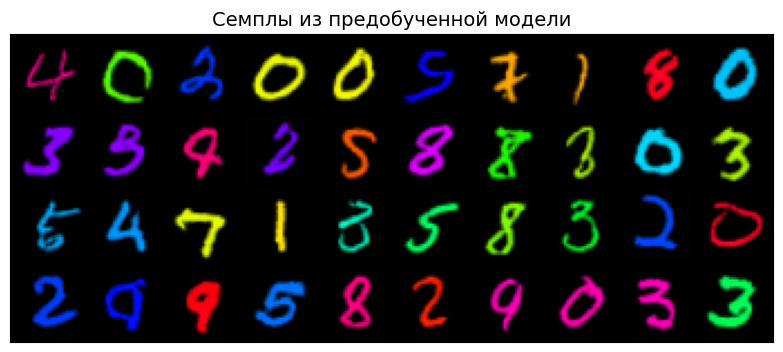

In [11]:
sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80.0,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False
}
visualize_model_samples(model, params=sampling_params, get_timesteps=get_timesteps_diff, title='Семплы из предобученной модели')

Для исследования того, насколько Rectified Flow помогает сокращать число шагов по схеме Эйлера без потери качества, нам понадобится зависимость метрики качества генерации от количества итераций семплирования. Ниже изображен такой график для метрики FID предобученной модели (измеренный на 10000 семплах).

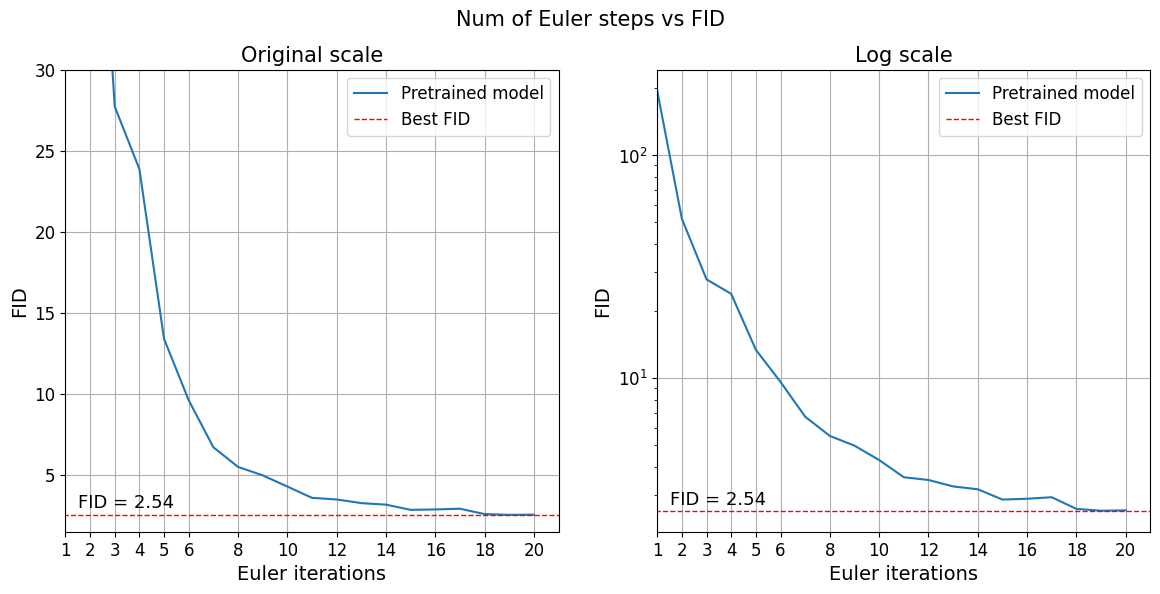

In [12]:
fid_model = np.array([194.77, 51.87, 27.73, 23.8732, 13.3967, 9.612, 6.71, 5.50, 4.976, 4.288, 3.59, 3.49, 3.265, 3.17, 2.85, 2.8745, 2.92, 2.588, 2.54, 2.55])

def plot_fid(fid_model):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    for i in range(2):
        ax[i].plot(np.arange(1, len(fid_model) + 1), fid_model, label='Pretrained model')
        ax[i].plot(np.arange(0, len(fid_model) + 2), fid_model.min() * np.ones(len(fid_model) + 2),
                   label='Best FID', linestyle='--', color='red', linewidth=1.0)
        ax[i].grid(True)
        ax[i].legend(fontsize=12)
        ax[i].set_xlim([1, 21])
        ax[i].set_xticks([1, 2, 3, 4, 5] + list(range(6, 21, 2)))
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel('Euler iterations', fontsize=14)
        ax[i].set_ylabel('FID', fontsize=14)

    ax[0].annotate('FID = 2.54', (1.5, 3), fontsize=13)
    ax[1].annotate('FID = 2.54', (1.5, 2.7), fontsize=13)
    ax[0].set_title('Original scale', fontsize=15)
    ax[0].set_ylim([1.5, 30.])
    ax[1].set_title('Log scale', fontsize=15)
    ax[1].set_yscale('log')
    fig.suptitle('Num of Euler steps vs FID', fontsize=15)
    plt.show()

plot_fid(fid_model)

## Модель Flow Matching

Небольшое напоминание про модель Flow Matching [[1]](https://arxiv.org/abs/2210.02747)[[2]](https://arxiv.org/abs/2302.00482)[[3]](https://arxiv.org/abs/2303.08797): она учится переводить семплы из произвольного распределения $p_0$ в произвольное распределение $p_1$.  Мы считаем, что на этапе обучения нам приходят пары $(\mathbf{X}_0, \mathbf{X}_1)$ из некоторого совместного распределения $p_{0, 1}$, при этом $\mathbf{X}_0 \sim p_0$ и $\mathbf{X}_1 \sim p_1$. В данном случае $p_0 = \mathcal{N}(0, I)$ — распределение шума, а $p_1 = p_{\text{data}}$ — распределение данных. По парам строится процесс интерполяции $\mathbf{X}_t = t \mathbf{X}_1 + (1 - t) \mathbf{X}_0$. На лекции мы доказывали, что если построить векторное поле
$$
    f_t^*(\mathbf{x}) = \mathbb{E}[\mathbf{X}_1 - \mathbf{X}_0 | \mathbf{X}_t = \mathbf{x}],
$$
то соответствующее ОДУ с начальным условием
$$
    \begin{cases}
        \mathrm{d} \mathbf{Y}_t = f_t(\mathbf{Y}_t) \mathrm{d} t;\\
        \mathbf{Y}_0 \sim p_0
    \end{cases}
$$
порождает такую же динамику распределений, что и процесс интерполяции: $p_{\mathbf{Y}_t} = p_{\mathbf{X}_t}$ для всех $t$. В частности, данное ОДУ переводит семплы из распределения $p_0$ в распределение $p_1$.

На практике, как обычно, мы пользуемся свойством УМО как наилучшего в $L_2$ предсказания и учим модель $f_t^{\theta}(\mathbf{x})$ на функционал
$$
    \int_0^1 \mathbb{E} \|f_t^{\theta}(\mathbf{X}_t) - (\mathbf{X}_1 - \mathbf{X}_0) \|^2 \mathrm{d} t \rightarrow \min \limits_{\theta}.
$$

Важнейшим свойством модели Flow Matching с линейным интерполянтом является то, что порожденное обученным ОДУ совместное распределение $p_{\mathbf{Y}_0, \mathbf{Y}_1}$ имеет меньшую транспортную цену, чем совместное распределение $p_{0, 1}$ пар, подаваемых во время обучения. Помимо снижения транспортной цены, обучение Flow Matching на семплах, полученных из некоторой ОДУ модели (например, из Flow Matching или диффузионной модели, обученной на независимых парах), приводит к уменьшению кривизны траекторий и, следовательно, к более эффективному семплингу. Так, в предельном случае, когда ОДУ имеет прямые траектории, генерацию можно сделать за один шаг по схеме Эйлера. Модель Flow Matching, использованную в таком сеттинге, принято называть Rectified Flow по названию оригинальной [статьи](https://arxiv.org/abs/2209.03003).

Целью домашки будет обучение Rectified Flow и проверка того, действительно ли и насколько спрямляются траектории.

## Использование диффузионной модели в режиме Flow Matching

В качестве исходной ОДУ модели, на парах из которой будет обучаться FM, мы возьмем предобученную диффузионную модель. При этом, если подумать, и исходная диффузионная модель, и будущий обученный FM будут решать одну и ту же задачу: предсказание шума/чистого семпла/разницы между шумом и чистым семплом по шумному входу. Логично в таком случае не обучать FM с нуля, а использовать предобученную диффузионную модель для его инициализации.

## Задача 1 (0.2 балла)

Пусть $D_\sigma(\mathbf{x}_\sigma)$ — оптимальный денойзер, обученный в VE режиме, то есть $D_\sigma(\mathbf{x}_\sigma) = \mathbb{E}[\mathbf{X} | \mathbf{X} + \sigma \mathbf{\varepsilon} = \mathbf{x}_\sigma]$, где $\mathbf{X} \sim p_{\text{data}}$ и $\mathbf{\varepsilon} \sim \mathcal{N}(0, I)$ — независимые величины. Рассмотрим процесс интерполяции $\mathbf{X}_t = t \mathbf{X}_1 + (1 - t)\mathbf{X}_0$, заданный моделью FM между $\mathbf{X}_0 = \mathbf{\varepsilon}$ и $\mathbf{X}_1 = \mathbf{X}$.

1) Выразите оптимальное векторное поле $f^*_t(\mathbf{x}_t)$, выучиваемое моделью FM, через оптимальный денойзер для модели FM $D^*_t(\mathbf{x}_t) = \mathbb{E}[\mathbf{X}_1 | \mathbf{X}_t = \mathbf{x}_t]$.

2) Выразите оптимальный денойзер $D_t^*(\mathbf{x}_t)$ для модели FM через оптимальный VE денойзер $D_\sigma$.

#### Решение.

1. $f^*_t(\mathbf{x}_t) = \mathbb{E}[\mathbf{X}_1 - \mathbf{X}_0|\mathbf{X}_t=\mathbf{x}_t] = D^*_t(\mathbf{x}_t) - \mathbb{E}[\mathbf{X}_0|\mathbf{X}_t=\mathbf{x}_t]=\left\{\mathbf{X_t} = t\mathbf{X_1} + (1-t)\mathbf{X_0}\right\}=D^*_t(\mathbf{x}_t) - \mathbb{E}\left[\frac{\mathbf{X_t} - \mathbf{X_1}t}{1-t}\Big|\mathbf{X}_t=\mathbf{x}_t\right] = \frac{D^*_t(\mathbf{x}_t) - \mathbf{x}_t}{1-t}$

2. $D^*_t(\mathbf{x}_t) =  \mathbb{E}[\mathbf{X}_1 |\mathbf{X}_t=\mathbf{x}_t] = \mathbb{E}[\mathbf{X}_1 |t\mathbf{X}_1 + (1-t)\mathbf{X}_0=\mathbf{x}_t] = \mathbb{E}\left[\mathbf{X}_1 \Big|\mathbf{X}_1 + \frac{(1-t)}{t}\mathbf{X}_0=\frac{\mathbf{x}_t}{t}\right] = D_{\frac{1-t}{t}}(\frac{\mathbf{x_t}}{t})$

Решением задачи будет некоторое представление $D_t^*(\mathbf{x}_t) = D_{\sigma(t)}(\varphi(\mathbf{x}_t, t))$ и $f_t^*(\mathbf{x}_t) = a(\mathbf{x}_t, t) \cdot D_t^*(\mathbf{x}_t) + b(\mathbf{x}_t, t)$. Новую модель Flow Matching мы будем параметризовать через FM-денойзер (и учить соответствующим образом), а инициализировать ее будем из VE-денойзера по полученным формулам.

In [13]:
class FMPrecond(nn.Module):
    def __init__(self, model, error_eps=1e-4):
        super().__init__()
        self.model = model # VE-денойзер
        self.error_eps = error_eps

    # выражаем FM денойзер через VE денойзер и возвращаем предсказание чистой картинки
    def forward(self, x_t, t, class_labels=None): 
        sigma = (1 - t) / (t + self.error_eps)
        x_sigma = x_t / (t + self.error_eps)
        return self.model(x_sigma, sigma, class_labels)

    # выражаем векторное поле f*_t(x_t) через предсказание оптимального денойзера D*_t(x_t) (pred)
    def to_velocity(self, x_t, t, denoiser_pred):
        return (denoiser_pred - x_t) / (1 - t + self.error_eps)

    # комбинируем первое и второе
    def velocity(self, x_t, t, class_labels=None):
        t = t[:, None, None, None]
        return (self.forward(x_t, t, class_labels) - x_t) / (1 - t + self.error_eps)


In [14]:
from copy import deepcopy

# model: DiffODE, обертка над оберткой :)
# model.model: EDMPrecond, обертка над нейросеткой, задающая VE денойзер

recflow = FMPrecond(deepcopy(model.model))
recflow.eval()

FMPrecond(
  (model): EDMPrecond(
    (model): CUNet(
      (inc): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(1, 64, eps=1e-05, affine=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): GroupNorm(1, 64, eps=1e-05, affine=True)
          (5): ReLU(inplace=True)
        )
      )
      (down1): Down(
        (maxpool_conv): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): DoubleConv(
            (double_conv): Sequential(
              (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): GroupNorm(1, 128, eps=1e-05, affine=True)
              (2): ReLU(inplace=True)
              (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (4): GroupNorm(1, 128, eps=1

Помимо самой предобученной модели и ее параметризации, преимуществом сведения FM к VE-денойзеру является возможность использовать все гиперпараметры, которые хорошо работали для исходной модели. В частности, это касается выбора моментов времени в качестве узлов для схемы Эйлера. Если все было реализовано правильно, должны получиться семплы, похожие на исходные семплы из модели (так как по сути мы использовали ту же модель, но с другим семплером, изначально разработанным для FM).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015684187..1.0251466].


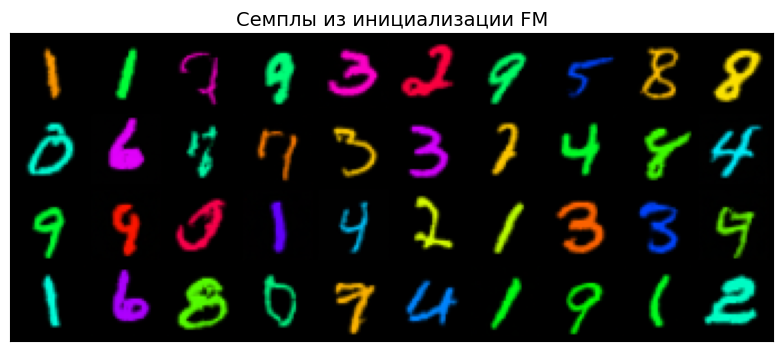

In [15]:
def get_timesteps_fm(params):
    sigmas = get_timesteps_diff(params)
    return 1 / (1 + sigmas)

sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80.0,
    'num_steps': 20, 
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False
}

visualize_model_samples(recflow, params=sampling_params, get_timesteps=get_timesteps_fm, diffusion=False, title='Семплы из инициализации FM')

## Задача 2 (0.2 балла)
Имплементируйте функционал обучения модели Rectified Flow на семплах из предобученной диффузионной модели и обучите модель. Как было обсуждено ранее, параметризуем мы модель через денойзер, поэтому и учить здесь будем на функционал денойзера (предсказание чистой картинки по шумной интерполяции).

Обратите внимание, что VE модель начинает семплирование из $\mathbf{\varepsilon} \cdot \sigma_{\text{max}}$ (здесь код для схемы Эйлера не производит умножение на $\sigma_{\text{max}}$, чтобы был общий код для FM и для VE). Помимо этого, sample_euler принимает на вход функцию, которая задает узлы дискретизации (get_timesteps_diff для диффузионной модели и get_timesteps_fm для FM).

In [ ]:
class RectifiedLoss:
    def __init__(self, diffusion, sampling_params, batch_dim, distr='rand'):
        self.diffusion = diffusion # предобученная диффузионная модель
        self.sampling_params = sampling_params # параметры семплирования из предобученной модели
        self.batch_dim = batch_dim # размерность одного батча на обучении
        self.distr = distr # распределение для семплирования моментов времени

    def sample_t(self, n_samples, device='cuda'):
        if self.distr == 'rand':
            return torch.rand(n_samples, device=device)

        if self.distr == 'logit':
            n = torch.randn(n_samples, device=device)
            return torch.sigmoid(n)

    def __call__(self, net):
        noise = torch.randn(self.batch_dim, device=self.sampling_params['device'])
        images = sample_euler(self.diffusion, noise * self.sampling_params["sigma_max"], self.sampling_params, get_timesteps_diff)[0]
        t = self.sample_t(self.batch_dim[0])[:, None, None, None]
        x_t = images * t + (1 - t) * noise
        denoiser_pred = net(x_t, t)
        loss = torch.mean((denoiser_pred - images) ** 2)
        log_imgs = {
            'noise': noise.cpu().detach(),
            'images': images.cpu().detach(),
            'x_t': x_t.cpu().detach(),
            'denoised': denoiser_pred.cpu().detach()
        }

        return loss, log_imgs


Как и ранее, для удобства можно пользоваться следующим кодом для обучения + визуализации.

In [17]:
from tqdm import tqdm
from IPython.display import clear_output
import copy
import os

def visualize_mappings(log_imgs, ax, n_pictures=4):
    img_vis = torch.cat((
            normalize(log_imgs['noise'])[:n_pictures],
            normalize(log_imgs['images'])[:n_pictures],
            normalize(log_imgs['x_t'])[:n_pictures],
            normalize(log_imgs['denoised'])[:n_pictures]),
        dim=0
    )
    img_grid = make_grid(img_vis, nrow=n_pictures) * 0.5 + 0.5
    ax.imshow(img_grid.permute(1, 2, 0).detach().cpu())

def visualize_training(recflow, diffusion, loss_history, log_imgs, sampling_params, n_pictures=4, n_pictures_sampling=2):
    fig, ax = plt.subplot_mosaic([['loss', 'denoising'],
                                   ['sampling', 'sampling']],
                                  figsize=(11, 9), layout="constrained")

    # loss visualization
    ax['loss'].plot(np.arange(len(loss_history)), loss_history)
    ax['loss'].grid(True)
    ax['loss'].set_title('Лосс на обучении', fontsize=17)
    ax['loss'].set_xlabel('Итерация', fontsize=14)
    ax['loss'].tick_params(labelsize=13)

    #denoising visualization
    remove_ticks(ax['denoising'])
    visualize_mappings(log_imgs, ax['denoising'], n_pictures=n_pictures)
    ax['denoising'].set_title('Денойзинг из модели', fontsize=17)

    #sampling
    noise = torch.randn_like(log_imgs['images'][:n_pictures_sampling]).cuda()

    remove_xticks(ax['sampling'])
    _, trajectory = sample_euler(
        diffusion, noise * sampling_params['sigma_max'], params=sampling_params, get_timesteps=get_timesteps_diff, save_history=True)

    _, rtrajectory = sample_euler(
        recflow, noise, params=sampling_params, get_timesteps=get_timesteps_fm, save_history=True)

    trajectory = torch.cat(trajectory, dim=0) * 0.5 + 0.5
    trajectory = trajectory.reshape(-1, n_pictures_sampling, *trajectory.shape[1:])
    rtrajectory = torch.cat(rtrajectory, dim=0) * 0.5 + 0.5
    rtrajectory = rtrajectory.reshape(-1, n_pictures_sampling, *rtrajectory.shape[1:])

    trajectory = torch.cat((trajectory, rtrajectory), dim=1).reshape(-1, *trajectory.shape[2:])
    n_pictures_sampling = n_pictures_sampling * 2
    trajectory = trajectory.reshape(len(trajectory) // n_pictures_sampling, n_pictures_sampling, *trajectory.shape[-3:]).permute(1, 0, 2, 3, 4).reshape(-1, *trajectory.shape[-3:])
    img_grid = make_grid(trajectory, nrow=len(trajectory) // n_pictures_sampling)

    #sampling visualization
    ax['sampling'].set_yticks(
        18 + 34 * np.arange(n_pictures_sampling),
        ['diffusion',] * (n_pictures_sampling // 2) + ['recflow',] * (n_pictures_sampling // 2)
    )
    ax['sampling'].imshow(img_grid.permute(1, 2, 0).detach().cpu())
    ax['sampling'].set_title('Семплы из модели', fontsize=17)

    plt.show()

def train(recflow, opt, loss_fn, n_iters, sampling_params, eval_every=100, save_every=1000,):
    loss_history = []

    with tqdm(total=n_iters) as pbar:
        for it in range(n_iters):
            opt.zero_grad()
            loss, log_imgs = loss_fn(recflow)
            loss.backward()
            loss_history.append(loss.item())
            opt.step()
        
            if it % eval_every == 0:
                recflow.eval()
                clear_output(wait=True)
                visualize_training(recflow, loss_fn.diffusion, loss_history, log_imgs, sampling_params)

            if it % save_every == 0:
                torch.save(recflow.state_dict(), os.path.join('checkpoints', 'rec_%d.pth' %(it,)))
            pbar.update(1)
            pbar.set_description('Loss: %.4g' % loss.item())

    return recflow

In [18]:
recflow.train()
opt = torch.optim.Adam(recflow.parameters(), lr=0.5e-5)
model.eval().requires_grad_(False)

# мы будем использовать одинаковые параметры для семплинга из
# предобученной диффузионки и обучаемого Rectified Flow

sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80.0,
    'num_steps': 20, # на 20 итерациях FID уже практически сошелся, больше будет слишком долго учиться
    'vis_steps': 10,
    'rho': 7.0,
    'stochastic': False,
}

batch_dim = [32, 3, 32, 32] # можно попробовать и больший размер батча
loss_fn = RectifiedLoss(model, sampling_params, batch_dim, distr='logit')
n_iters = 15000 # может варьироваться в зависимости от размера батча

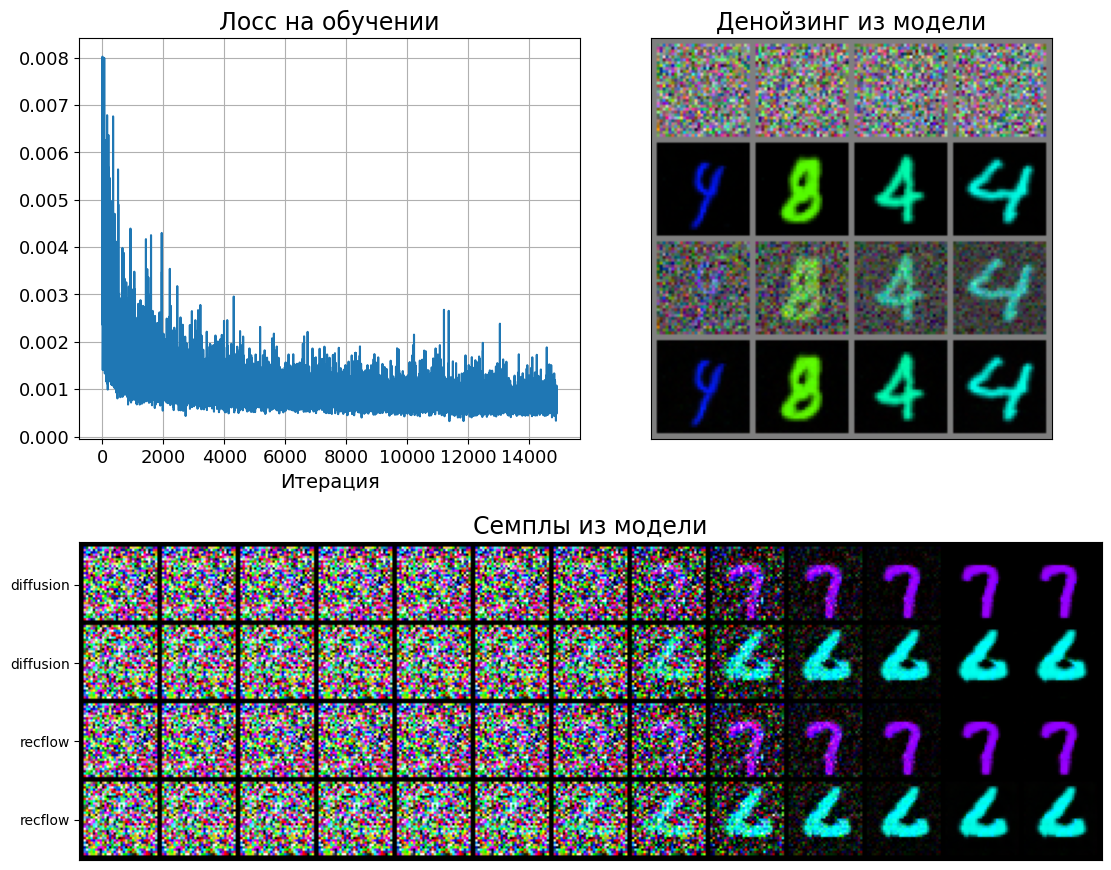

Loss: 0.0005834: 100%|██████████| 15000/15000 [42:56<00:00,  5.82it/s]


In [43]:
student = train(recflow, opt, loss_fn, n_iters, sampling_params, eval_every=100, save_every=1000)

## Задача 3 (0.4 балла)

**(0.1 балла)** Обучите модель Rectified Flow.

Для отслеживания сходимости можно (но не требуется) добавить к обучению подсчет метрики кривизны траектории, которая для ОДУ $\mathrm{d} \mathbf{Y}_t = f_t(\mathbf{Y}_t) \mathrm{d} t$ определяется как
$$
    l(\mathbf{Y}) = \int\limits_{0}^{1} \mathbb{E} \|f_t(\mathbf{Y}_t) - (\mathbf{Y}_1 - \mathbf{Y}_0)\|^2 \mathrm{d} t
$$

**(0.1 балла)** Для обученной модели посчитайте FID (на 10к семплах) на 1-10 шагах и визуализируйте на одном графике с FID предобученной модели. Проанализируйте полученные результаты.

**(0.2 балла)** начисляется, если модель бьет предобученную на 1-6 шагах.

**Замечание:** качество с точки зрения FID получится не очень хорошее. Для выбивания лучшего качества нужно докручивать хаков/прилично увеличивать компьют.

Функции для подсчета FID даны ниже.

In [19]:
ckpts = torch.load("checkpoints/rec_14000.pth")
recflow.load_state_dict(ckpts)

<All keys matched successfully>

In [20]:
import shutil
from tqdm import tqdm

# сохраним семплы из модели для дальнейшего подсчета FID у FM модели
def save_model_samples(name, model, params, batch_size, num_samples, **model_kwargs):
    if os.path.exists(name):
        shutil.rmtree(name)

    os.makedirs(name, exist_ok=True)
    count = 0

    with tqdm(total= num_samples) as pbar:
        while count < num_samples:
            cur_batch_size = min(num_samples - count, batch_size)
            noise = torch.randn(cur_batch_size, 3, 32, 32).cuda()

            out, trajectory = sample_euler(model, noise, params, get_timesteps_fm, **model_kwargs)
            out = (out * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
            for i in range(out.shape[0]):
                img = Image.fromarray(out[i])
                n_digits = len(str(count))
                img_name = (6 - n_digits) * '0' + str(count) + '.png'
                img.save(os.path.join(name, img_name))
                count += 1
                pbar.update(1)
                pbar.set_description('%d images saved' % (count,))

recflow.eval()
for i in range(1, 11):
    sampling_params = {
        'device': 'cuda',
        'sigma_min': 0.02,
        'sigma_max': 80.0,
        'num_steps': i, # на 20 итерациях FID уже практически сошелся, больше будет слишком долго учиться
        'vis_steps': 10,
        'rho': 7.0,
        'stochastic': False,
    }
    save_model_samples(f'rf_samples_{i}', recflow, sampling_params, batch_size=128, num_samples=10000)

1509 images saved:  15%|█▌        | 1509/10000 [00:07<00:43, 196.15it/s]


KeyboardInterrupt: 

In [ ]:
# возьмем реализацию подсчета FID из EDM
from fid import calculate_inception_stats, calculate_fid_from_inception_stats
from dnnlib.util import open_url

def calc_fid(image_path, ref_path, num_expected, batch):
    with open_url(ref_path) as f:
        ref = dict(np.load(f))

    mu, sigma = calculate_inception_stats(image_path=image_path, num_expected=num_expected, max_batch_size=batch)
    fid = calculate_fid_from_inception_stats(mu, sigma, ref['mu'], ref['sigma'])
    return fid

In [46]:
fid_rf = []
for i in range(1, 11):
    fid_rf.append(calc_fid(f"rf_samples_{i}", "cmnist_train.npz", 10000, 128))

Loading Inception-v3 model...
Loading images from "rf_samples_1"...
Calculating statistics for 10000 images...


100%|██████████| 79/79 [00:06<00:00, 12.83batch/s]


Loading Inception-v3 model...
Loading images from "rf_samples_2"...
Calculating statistics for 10000 images...


100%|██████████| 79/79 [00:04<00:00, 16.01batch/s]


Loading Inception-v3 model...
Loading images from "rf_samples_3"...
Calculating statistics for 10000 images...


100%|██████████| 79/79 [00:04<00:00, 16.47batch/s]


Loading Inception-v3 model...
Loading images from "rf_samples_4"...
Calculating statistics for 10000 images...


100%|██████████| 79/79 [00:04<00:00, 16.68batch/s]


Loading Inception-v3 model...
Loading images from "rf_samples_5"...
Calculating statistics for 10000 images...


100%|██████████| 79/79 [00:04<00:00, 16.55batch/s]


Loading Inception-v3 model...
Loading images from "rf_samples_6"...
Calculating statistics for 10000 images...


100%|██████████| 79/79 [00:04<00:00, 16.74batch/s]


Loading Inception-v3 model...
Loading images from "rf_samples_7"...
Calculating statistics for 10000 images...


100%|██████████| 79/79 [00:06<00:00, 12.70batch/s]


Loading Inception-v3 model...
Loading images from "rf_samples_8"...
Calculating statistics for 10000 images...


100%|██████████| 79/79 [00:04<00:00, 16.70batch/s]


Loading Inception-v3 model...
Loading images from "rf_samples_9"...
Calculating statistics for 10000 images...


100%|██████████| 79/79 [00:04<00:00, 16.97batch/s]


Loading Inception-v3 model...
Loading images from "rf_samples_10"...
Calculating statistics for 10000 images...


100%|██████████| 79/79 [00:04<00:00, 16.71batch/s]


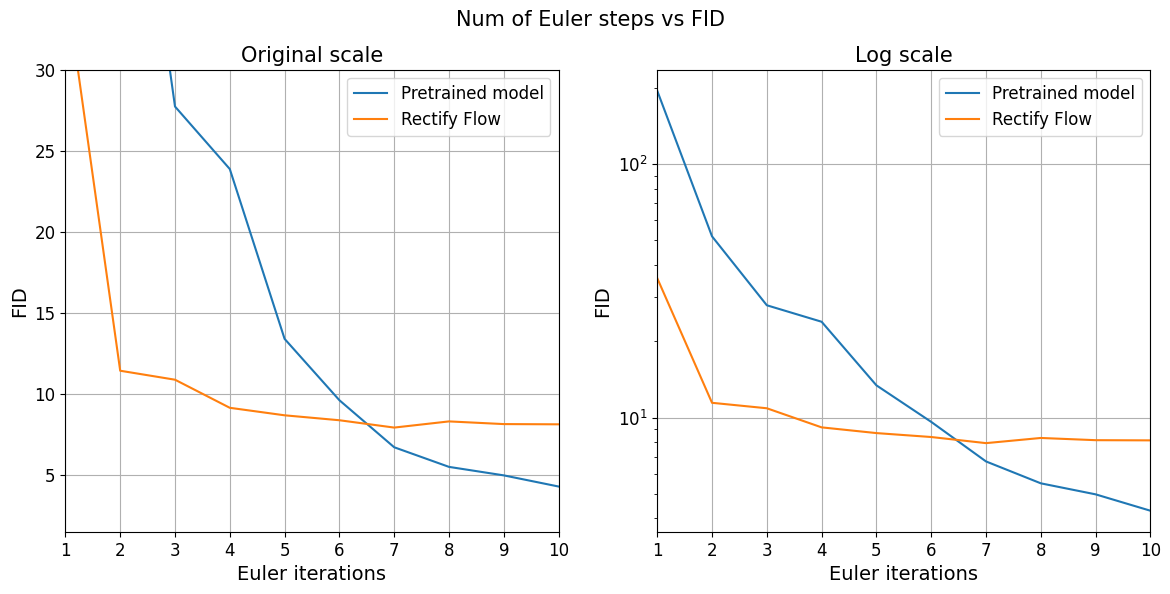

In [34]:
fid_model = np.array([194.77, 51.87, 27.73, 23.8732, 13.3967, 9.612, 6.71, 5.50, 4.976, 4.288, 3.59, 3.49, 3.265, 3.17, 2.85, 2.8745, 2.92, 2.588, 2.54, 2.55])
fid_rf = np.array([35.48514261044581, 11.431172490714397, 10.877680099485488, 9.144648260649355, 8.681529119310872, 8.376761919073145, 7.924235272443347, 8.305318110363128, 8.139869291220034, 8.125604567604586])

def plot_fid(fid_model):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    for i in range(2):
        ax[i].plot(np.arange(1, len(fid_model[:10]) + 1), fid_model[:10], label='Pretrained model')
        ax[i].plot(np.arange(1, len(fid_rf) + 1), fid_rf, label='Rectify Flow')
        ax[i].grid(True)
        ax[i].legend(fontsize=12)
        ax[i].set_xlim([1, 10])
        ax[i].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel('Euler iterations', fontsize=14)
        ax[i].set_ylabel('FID', fontsize=14)

    ax[0].set_title('Original scale', fontsize=15)
    ax[0].set_ylim([1.5, 30.])
    ax[1].set_title('Log scale', fontsize=15)
    ax[1].set_yscale('log')
    fig.suptitle('Num of Euler steps vs FID', fontsize=15)
    plt.show()

plot_fid(fid_model)

## Задача 4 (0.2 балла)

**(0.1 балла)** Визуализируйте выходы предобученной модели и Rectified Flow на нескольких одинаковых входных шумах, используя 1-10 шагов в схеме Эйлера. Согласуются ли визуальные результаты с полученными значениями FID?

**(0.1 балла)** Сгенерируйте батч шума и запустите генерацию по схеме Эйлера из предобученной модели и из Rectified Flow. Возьмите случайный набор пикселей из батча и визуализируйте траекторию пикселей на отрезке $[0, 1]$ (аналогично Fig.6 из статьи [InstaFlow](https://arxiv.org/pdf/2309.06380)). Оцените, насколько сильно прямее они становятся.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04560089..0.99789464].


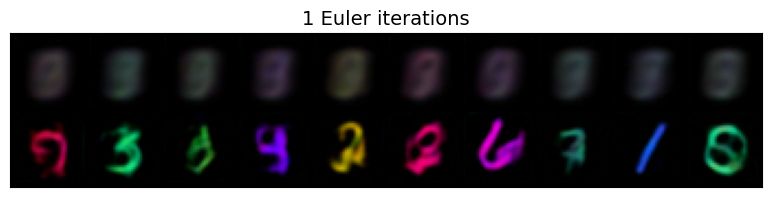

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027550817..0.9988832].


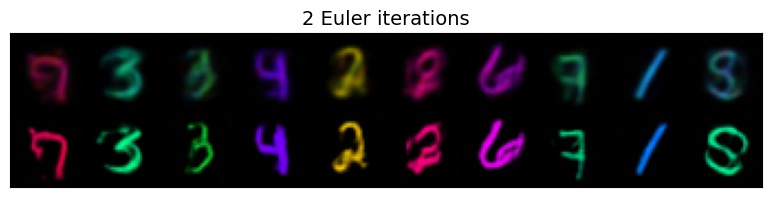

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.044902325..1.0102651].


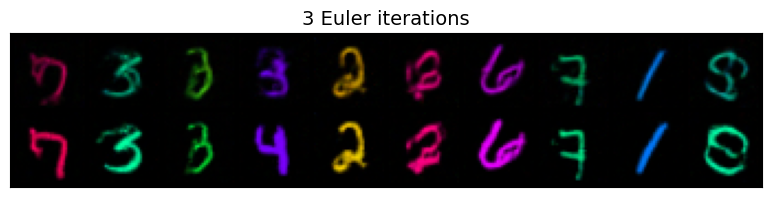

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02582413..1.0129361].


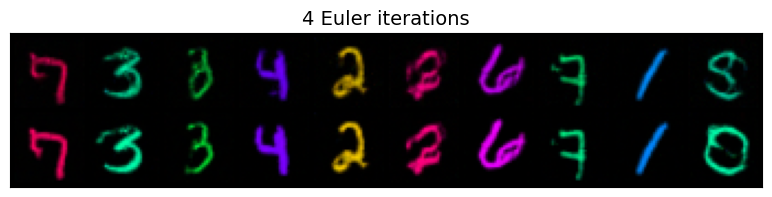

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01938194..1.0146803].


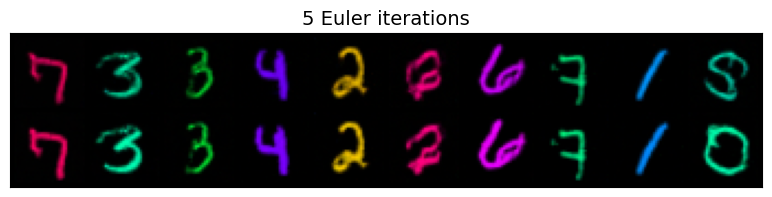

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0219087..1.0195997].


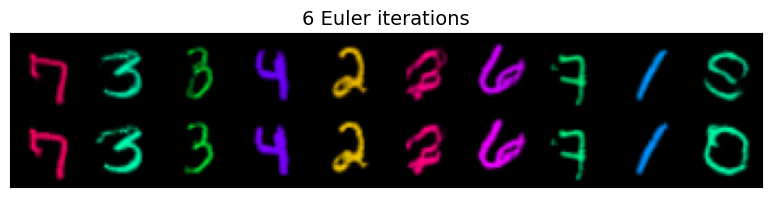

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02024889..1.0182991].


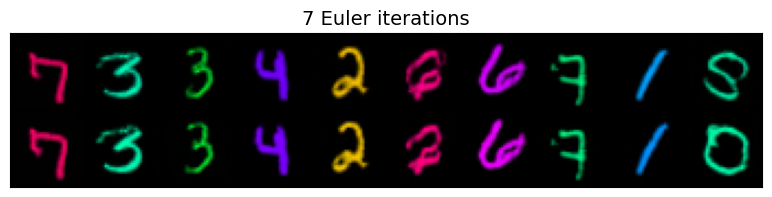

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019627154..1.0145653].


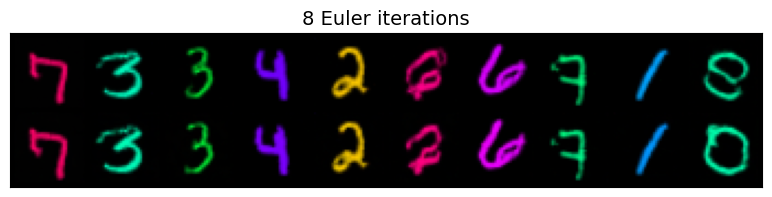

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022464633..1.0116887].


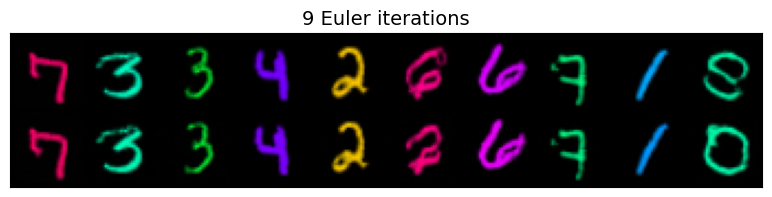

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02321738..1.0084449].


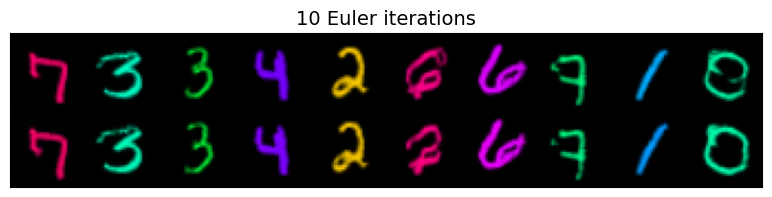

In [74]:
noise = torch.randn(10, 3, 32, 32).cuda()
for i in range(1, 11):
    sampling_params = {
            'device': 'cuda',
            'sigma_min': 0.02,
            'sigma_max': 80.0,
            'num_steps': i,
            'vis_steps': 10,
            'rho': 7.0,
            'stochastic': False,
    }
    out_diff, _ = sample_euler(model, noise * sampling_params["sigma_max"], sampling_params, get_timesteps_diff)
    out_rf, _ = sample_euler(recflow, noise, sampling_params, get_timesteps_fm)
    out_diff = out_diff * 0.5 + 0.5
    out_rf = out_rf * 0.5 + 0.5
    out = torch.cat((out_diff, out_rf), 0)
    visualize_batch(out.detach().cpu(), title=f"{i} Euler iterations", ncol=2)

Согласуются. Видно, что на первой итерации предобученная модель вообще без цвета выдаёт, при этом RF сразу даёт цвет. Правда после 6 итерации для меня разницы нет, хотя FID говорит, что предобученная модель там лучше.

In [67]:
def get_timesteps_fm1(params):
    return torch.linspace(0 + 1e-4, 1, steps=sampling_params["num_steps"], device=sampling_params["device"])

model = CUNet(in_channels=3, out_channels=3, noise_channels=128, base_factor=64, emb_channels=128)
model = EDMPrecond(model)
model.load_state_dict(torch.load('cunet.pt'))
model = FMPrecond(deepcopy(model)).eval().cuda()

noise = torch.randn(5, 3, 32, 32).cuda()
sampling_params = {
            'device': 'cuda',
            'sigma_min': 0.02,
            'sigma_max': 80.0,
            'num_steps': 50,
            'vis_steps': 20,
            'rho': 7.0,
            'stochastic': False,
}
_, traj_dif = sample_euler(model, noise, sampling_params, get_timesteps_fm1, save_history=True, normalize=False)
_, traj_rf = sample_euler(recflow, noise, sampling_params, get_timesteps_fm1, save_history=True, normalize=False)
b = torch.arange(len(noise))
c = torch.randint(3, (len(noise),))
h = torch.ones((len(noise),)) * int(16)
w = torch.ones((len(noise),)) * int(16)
h = h.to(int)
w = w.to(int)

In [68]:
diff = torch.zeros((len(traj_dif), len(noise)))
rf = torch.zeros((len(traj_rf), len(noise)))

for i in range(diff.shape[0]):
    diff[i] = traj_dif[i][b, c, h, w].detach().cpu()
    rf[i] = traj_rf[i][b, c, h, w].detach().cpu()
diff = diff * 0.5 + 0.5
rf = rf * 0.5 + 0.5
diff = diff.transpose(0, 1)
rf = rf.transpose(0, 1)

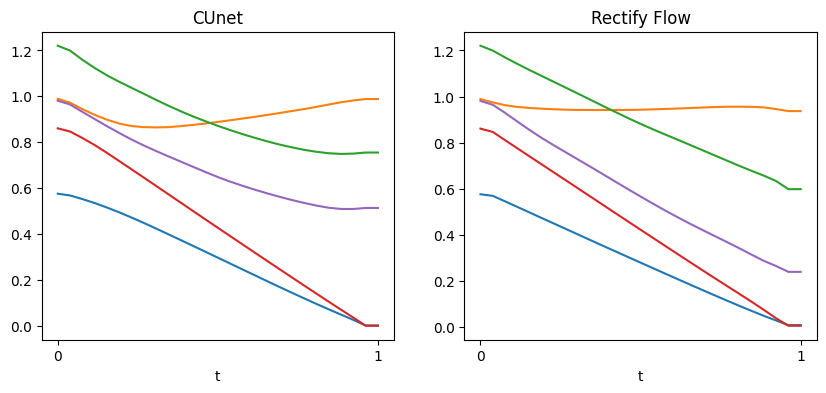

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for i in range(len(noise)):
    ax[0].plot(diff[i])
    ax[1].plot(rf[i])
    ax[0].set_xlabel("t")
    ax[0].set_xticks([0, len(traj_dif) - 1])
    ax[0].set_xticklabels(["0", "1"])
    ax[0].set_title("CUnet")
    ax[1].set_xlabel("t")
    ax[1].set_xticks([0, len(traj_dif) - 1])
    ax[1].set_xticklabels(["0", "1"])
    ax[1].set_title("Rectify Flow")